<a href="https://colab.research.google.com/github/nidarshana-30/Deep-learning-/blob/main/Lungs%20cancer%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**LUNG CANCER PREDICTION USING VGG16(Visual Geometry Group 16-layer)**

In [ ]:
!nvidia-smi

Thu Nov 14 08:27:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **IMPORTING**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **DATA AUGMENTED DATASET**

In [ ]:
from zipfile import ZipFile
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/lung_colon_image_set.zip'

with ZipFile(data_path,'r') as zip:
    zip.extractall()
print('The data set has been extracted.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
The data set has been extracted.


In [ ]:
import os
import zipfile
from google.colab import drive
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/lung_colon_image_set.zip'
extract_path = '/content/lung_images'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    os.makedirs(extract_path, exist_ok=True)
    for member in zip_ref.namelist():
        if member.startswith('lung_image_sets/'):
            zip_ref.extract(member, extract_path)
lung_image_path = os.path.join(extract_path, 'lung_image_sets')
lung_classes = os.listdir(lung_image_path)
total_images = 0
for class_folder in lung_classes:
    class_path = os.path.join(lung_image_path, class_folder)
    num_images = len(os.listdir(class_path))
    total_images += num_images
    print(f"Class '{class_folder}' contains {num_images} images.")

print(f"Total images extracted: {total_images}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Class 'lung_scc' contains 5000 images.
Class 'lung_n' contains 5000 images.
Class 'lung_aca' contains 5000 images.
Total images extracted: 15000


# **CLASSIFICATION**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Class 'lung_scc' contains 5000 images.
Class 'lung_n' contains 5000 images.
Class 'lung_aca' contains 5000 images.
Total images across all categories: 15000


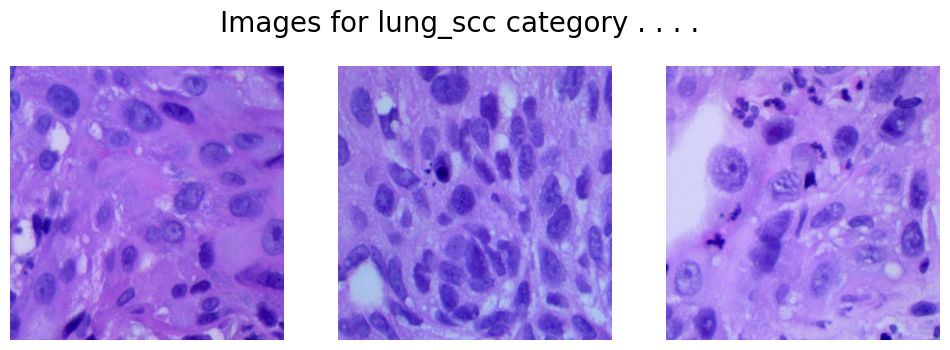

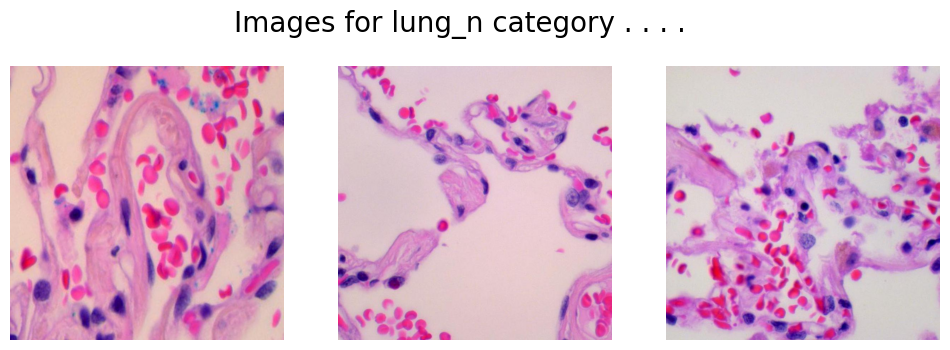

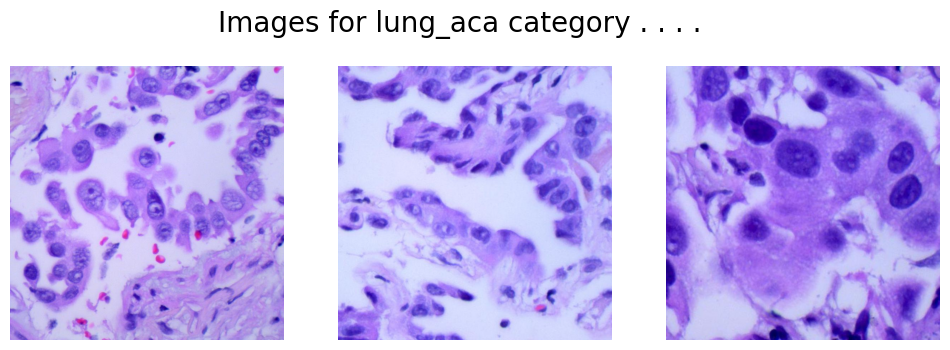

In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from google.colab import drive
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/lung_colon_image_set.zip'
extract_path = '/content/lung_images'
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
path = os.path.join(extract_path, 'lung_image_sets')
classes = os.listdir(path)
total_images = 0
for cat in classes:
    image_dir = os.path.join(path, cat)
    num_images = len(os.listdir(image_dir))
    total_images += num_images
    print(f"Class '{cat}' contains {num_images} images.")

print(f"Total images across all categories: {total_images}")
for cat in classes:
    image_dir = os.path.join(path, cat)
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img_path = os.path.join(image_dir, images[k])
        img = np.array(Image.open(img_path))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

# **DATA PREPARATION FOR TRAINING**

In [ ]:

IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
IMG_SIZE = 256
X = []
Y = []
for i, cat in enumerate(classes):
    image_dir = os.path.join(path, cat)
    images = glob(f'{image_dir}/*.jpeg')

    for image in images:
        img = cv2.imread(image)
        if img is not None:
            img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img_resized)
            Y.append(i)
X = np.array(X)
Y = np.array(Y)
one_hot_encoded_Y = pd.get_dummies(Y).values
print("Shape of X (images):", X.shape)
print("Shape of Y (labels):", Y.shape)
print("Shape of one-hot encoded Y:", one_hot_encoded_Y.shape)


Shape of X (images): (15000, 256, 256, 3)
Shape of Y (labels): (15000,)
Shape of one-hot encoded Y: (15000, 3)


# **DATA SPLITTING**

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
												test_size = SPLIT,
												random_state = 2022)
print(X_train.shape, X_val.shape)


(12000, 256, 256, 3) (3000, 256, 256, 3)


# **MODEL DEVELOPEMENT**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense, Flatten, Conv2D, MaxPooling2D
model = Sequential([
    Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3), padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(3, activation='softmax')
])


### **VGG16**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load VGG16 model, excluding the top layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze initial layers to retain learned features
for layer in vgg16_base.layers:
    layer.trainable = False

# Add new layers on top of VGG16
x = vgg16_base.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)  # Adjust the final layer for the number of classes

# Define new model
model = Model(inputs=vgg16_base.input, outputs=output)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 23,136,835 (88.26 MB)

 Trainable params: 8,422,147 (32.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

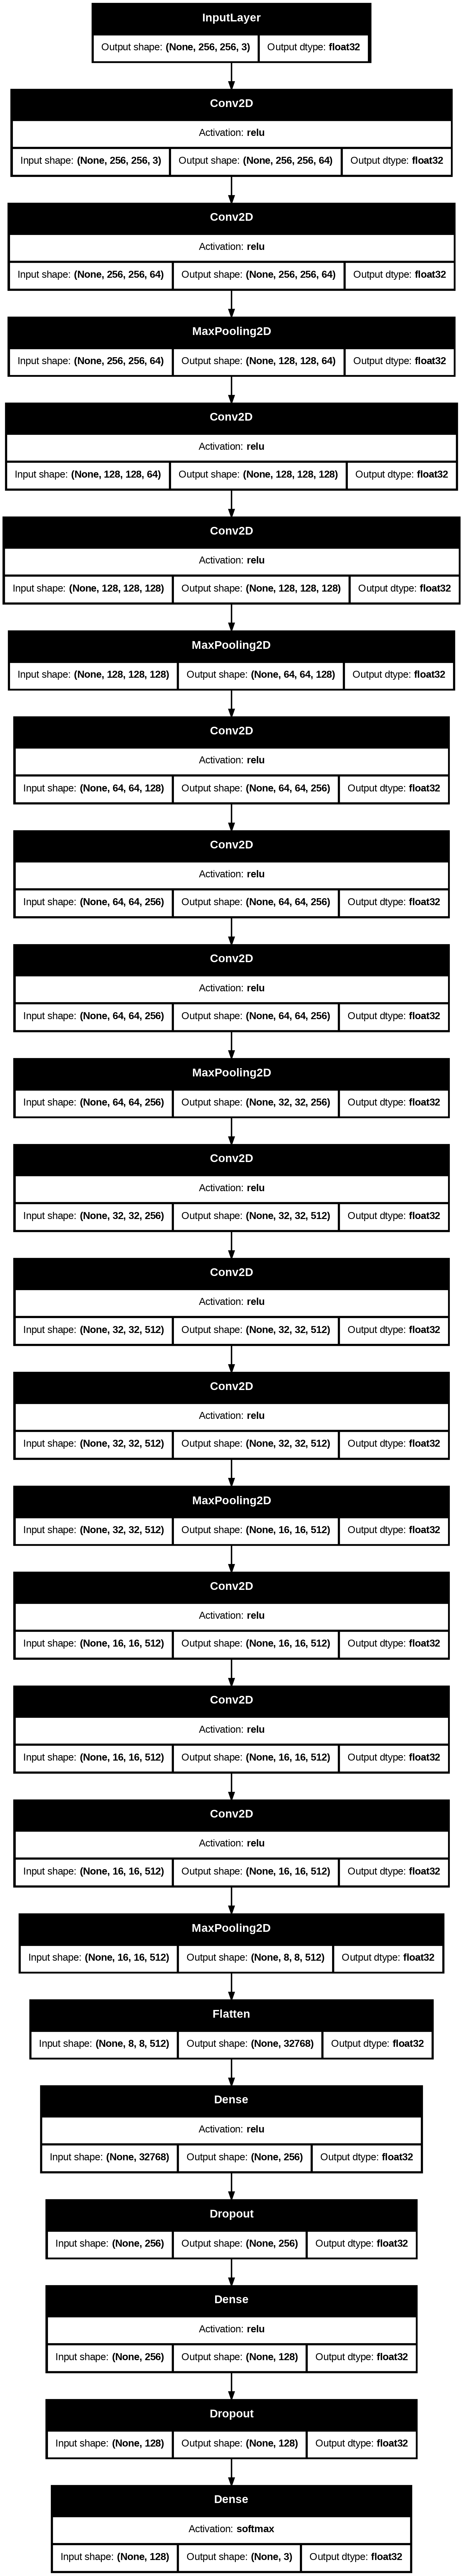

In [ ]:
keras.utils.plot_model(
	model,
	show_shapes = True,
	show_dtype = True,
	show_layer_activations = True
)

### **PARAMETERS**

In [ ]:
model.compile(
	optimizer = 'adam',
	loss = 'categorical_crossentropy',
	metrics = ['accuracy']
)


# **MODEL TRAINING**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
es = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1, min_lr=1e-6)
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=BATCH_SIZE,
    callbacks=[es, lr]
)


Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 144s 618ms/step - accuracy: 0.7783 - loss: 8.2383 - val_accuracy: 0.9670 - val_loss: 0.1873 - learning_rate: 0.0010
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 143s 444ms/step - accuracy: 0.9461 - loss: 0.2758 - val_accuracy: 0.9577 - val_loss: 0.1403 - learning_rate: 0.0010
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 142s 443ms/step - accuracy: 0.9631 - loss: 0.1429 - val_accuracy: 0.9723 - val_loss: 0.1095 - learning_rate: 0.0010
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 136s 414ms/step - accuracy: 0.9635 - loss: 0.1466 - val_accuracy: 0.9733 - val_loss: 0.0958 - learning_rate: 0.0010
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 87s 443ms/step - accuracy: 0.9776 - loss: 0.0806 - val_accuracy: 0.9790 - val_loss: 0.0946 - learning_rate: 0.0010
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 142s 444ms/step - accuracy: 0.9790 - loss: 0.0811 - val_accuracy: 0.9787 - val_loss: 0.0765 - learning_rate: 0.0010
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 282s 1s/step - accuracy: 

# **MODEL EVALUATION**

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
Y_pred = model.predict(X_val)
Y_val_labels = np.argmax(Y_val, axis=1)
Y_pred_labels = np.argmax(Y_pred, axis=1)
print(classification_report(Y_val_labels, Y_pred_labels, target_names=classes))
print(f"Accuracy: {accuracy_score(Y_val_labels, Y_pred_labels) * 100:.2f}%")


94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step
              precision    recall  f1-score   support

    lung_scc       0.97      0.98      0.98       987
      lung_n       1.00      1.00      1.00       977
    lung_aca       0.99      0.97      0.98      1036

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Accuracy: 98.60%


# **VISUALIZATION**

94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 160ms/step


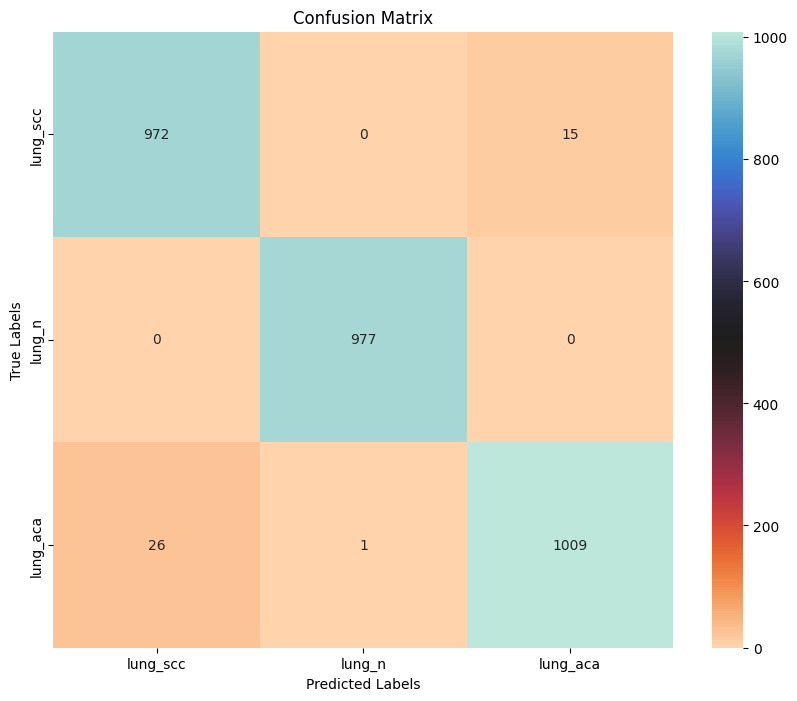

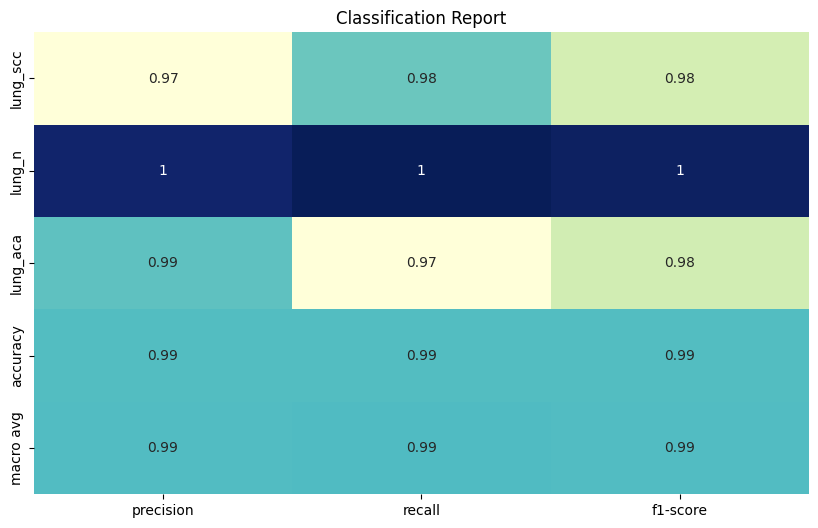

Accuracy: 98.60%


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
Y_pred = model.predict(X_val)
Y_val_labels = np.argmax(Y_val, axis=1)
Y_pred_labels = np.argmax(Y_pred, axis=1)

conf_matrix = confusion_matrix(Y_val_labels, Y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="icefire_r", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(Y_val_labels, Y_pred_labels, target_names=classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", cbar=False)
plt.title("Classification Report")
plt.show()

accuracy = accuracy_score(Y_val_labels, Y_pred_labels) * 100
print(f"Accuracy: {accuracy:.2f}%")


# **CONCLUSION**




This project aimed to classify breast cancer images using deep learning techniques. Initially, a custom **CNN model** achieved **73%** accuracy. To enhance performance, a **VGG16** pre-trained model was integrated using transfer learning, which significantly improved accuracy of about **98%.**

 Techniques like EarlyStopping and ReduceLROnPlateau were utilized to optimize training and prevent overfitting.

The project highlights the power of transfer learning in medical image analysis and establishes a foundation for developing AI-driven diagnostic tools in healthcare.